In [61]:
import numpy as np
import os
from astropy import wcs
from astropy.io import fits
from matplotlib import pyplot as plt 
from astropy import units as u
from photutils import DAOStarFinder
from astropy.io import fits
from astropy.visualization import *
from astropy.stats import mad_std
from astrofyp_functions import *
from astroquery.vizier import Vizier
from astropy.coordinates import Angle
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy import units as u
Vizier.ROW_LIMIT = -1

In [3]:
# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
# plt.rc('font', family = 'serif', serif = 'cmr10') 
# plt.rcParams.update({# Use mathtext, not LaTeX
#                             'text.usetex': True,
#                             # Use the Computer modern font
#                             'font.family': 'serif',
#                             'font.serif': 'cmr10',
#                             'mathtext.fontset': 'cm',
#                             })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']

# World Coordinate System Definition 

In [64]:
os.listdir('astrometric_obs_data/')

['berkeley28_V_wcs.fits', '.DS_Store', 'NGC2324_V_wcs.fits']

In [42]:
temp_file_name = 'astrometric_obs_data/berkeley28_V_wcs.fits'
hdulist = fits.open(temp_file_name)
tWCS = wcs.WCS(hdulist[0].header) #global variable

In [4]:
def starfinder(data, thrs, plot_cond):

    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = 6., threshold = thrs*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    if plot_cond == True: 
        plt.scatter(mst_sources['xcentroid'], mst_sources['ycentroid'], facecolors='none', edgecolors='lime')
        for i in range(0, len(mst_sources)):
            plt.annotate((i + 1), xy = (mst_sources['xcentroid'][i], mst_sources['ycentroid'][i]), fontsize= 5)
        plt.imshow(data, vmin = data.mean() - data.std(), vmax = data.mean() + data.std(), cmap = 'gist_yarg'); plt.show()


    return mst_sources

## WCS Conversion 

In [5]:
def WCS_conversion(file_path):
    '''
    INPUT - .fits image for reading the WCS from the header, DAO Sources from a given image
    FUNCTION - Uses (x and y) centroid positions and the wcs to convert pixel values into RA and DEC (J2000)
    OUTPUT - An array of WCS values for each source in the fits file. where [n][0] - RA and [n][1] - DEC. And RA, DEC for centre-frame. 
    '''

    hdulist = fits.open(file_path)
    data = fits.getdata(file_path)

    DAO_sources  = starfinder(data, 6, True) # calling the star finder function 

    target_RADEC = []

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    for idx in range(0, len(DAO_sources)):
        world = w.pixel_to_world(DAO_sources['xcentroid'][idx], DAO_sources['ycentroid'][idx])
        target_RADEC.append(world)

    centre =  w.pixel_to_world(np.shape(data)[0]/2, np.shape(data)[1]/2)
    
    return target_RADEC, centre

def Pixel_conversion(RA, DEC, file_path): 
    coords = SkyCoord(RA, DEC, unit = 'deg')
    
    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header)

    return w.world_to_pixel(coords)

def single_WCS_conversion(x_pix, y_pix, file_path): 
    hdulist = fits.open(file_path)
    w = wcs.WCS(hdulist[0].header)

    return w.pixel_to_world(x_pix, y_pix)


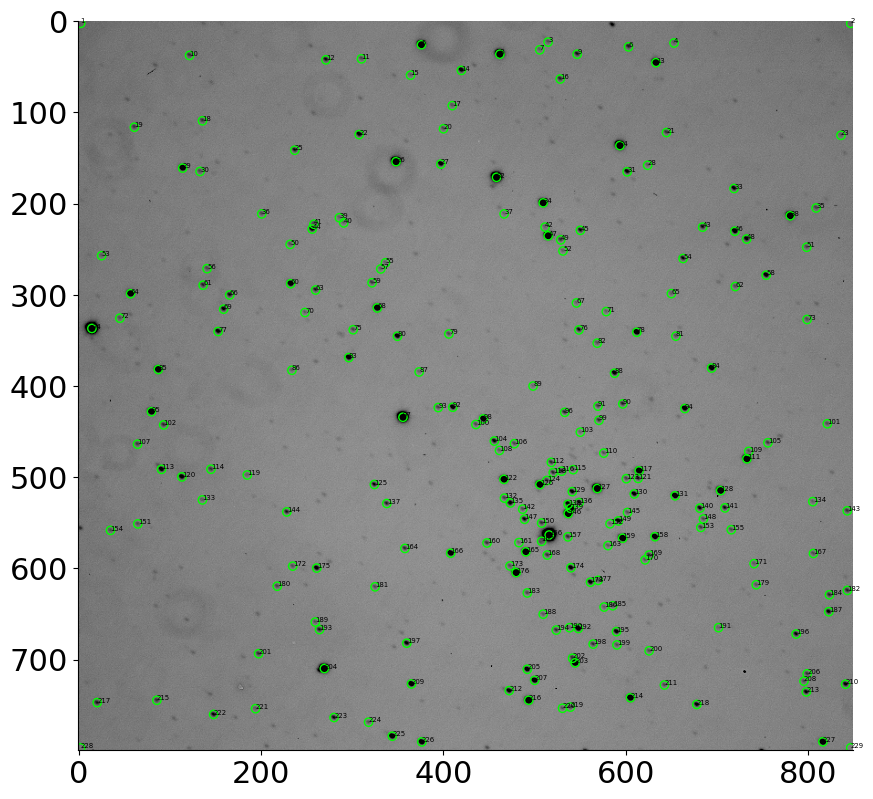

(229,)
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (103.05279967, 2.93591438)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (103.12101267, 3.01111063)>
0.1014641191933967


In [40]:
tar, cnt = WCS_conversion(temp_file_name)
print(np.shape(tar))
print(cnt)

print(edge)
edge = single_WCS_conversion(0, 0, temp_file_name)
sep = cnt.separation(edge).degree
print(sep)

In [8]:
def find_nearest(array, value):
    array = np.asarray(array); idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [70]:
def APASS_query(frame_center):
    edge = tWCS.pixel_to_world(0, 0)
    query_radius = frame_center.separation(edge).degree # returns seperation in correct unit. 
    print(query_radius)

    return(Vizier.query_region(coord.SkyCoord(frame_center, frame='fk5'), radius=Angle(query_radius, "deg"),  catalog='apass9')[0])

catalog_result = APASS_query(cnt)
thrs = catalog_result['e_Vmag'].mean() + catalog_result['e_Vmag'].std()
catalog_result = catalog_result[np.where(catalog_result['DEJ2000'] > 0) and np.where(catalog_result['e_Vmag'] < thrs)]
test_RA = catalog_result['RAJ2000']
test_DEC = catalog_result['DEJ2000']

catalog_result

0.1014641191933967


recno,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,Field,nobs,mobs,B-V,e_B-V,Vmag,e_Vmag,Bmag,e_Bmag,g_mag,e_g_mag,r_mag,e_r_mag,i_mag,e_i_mag
,deg,deg,arcsec,arcsec,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int32,float64,float64,float32,float32,int64,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
22171984,103.073290,2.845889,0.119,0.410,20120175,2,10,0.722,0.032,14.249,0.030,14.971,0.011,14.557,0.022,14.065,0.011,13.937,0.017
22171985,103.061015,2.842373,0.747,0.408,20150174,3,5,0.901,0.000,15.410,0.000,16.311,0.000,15.816,0.000,15.072,0.010,--,--
22171986,103.061556,2.842310,0.535,0.708,20150174,4,13,0.893,0.042,15.469,0.038,16.361,0.017,15.840,0.028,15.151,0.034,14.919,0.073
22171989,103.073205,2.845877,0.835,0.475,20150174,7,20,0.582,0.099,14.278,0.061,14.860,0.078,14.468,0.036,14.041,0.088,13.832,0.058
22171990,103.073223,2.845777,0.452,0.673,20150174,4,11,0.668,0.174,14.165,0.070,14.833,0.160,14.477,0.008,13.943,0.000,13.871,0.044
22171991,103.074834,2.851448,0.633,0.717,20150174,9,36,1.256,0.148,14.468,0.045,15.724,0.141,15.074,0.062,13.923,0.038,13.378,0.040
22171996,103.023179,2.845773,0.971,0.414,20150174,2,8,1.806,0.028,13.822,0.028,15.627,0.000,14.709,0.023,13.209,0.050,12.291,0.000
22171997,103.023381,2.845813,0.697,0.529,20150174,4,13,1.765,0.123,13.935,0.080,15.700,0.094,14.733,0.062,13.128,0.043,12.439,0.000


In [75]:
obs_index = []; cat_index = []

catalog_coord = SkyCoord(catalog_result['RAJ2000'], catalog_result['DEJ2000'], unit = 'deg')

obs_idx = 0; cat_idx = 0 
for obs_coord in tar:
    
    sep2tar = obs_coord.separation(catalog_coord).degree
    if sep2tar.min() < 1e-5:
        obs_index.append(obs_idx)

    obs_idx += 1 



0.033950436353301604
0


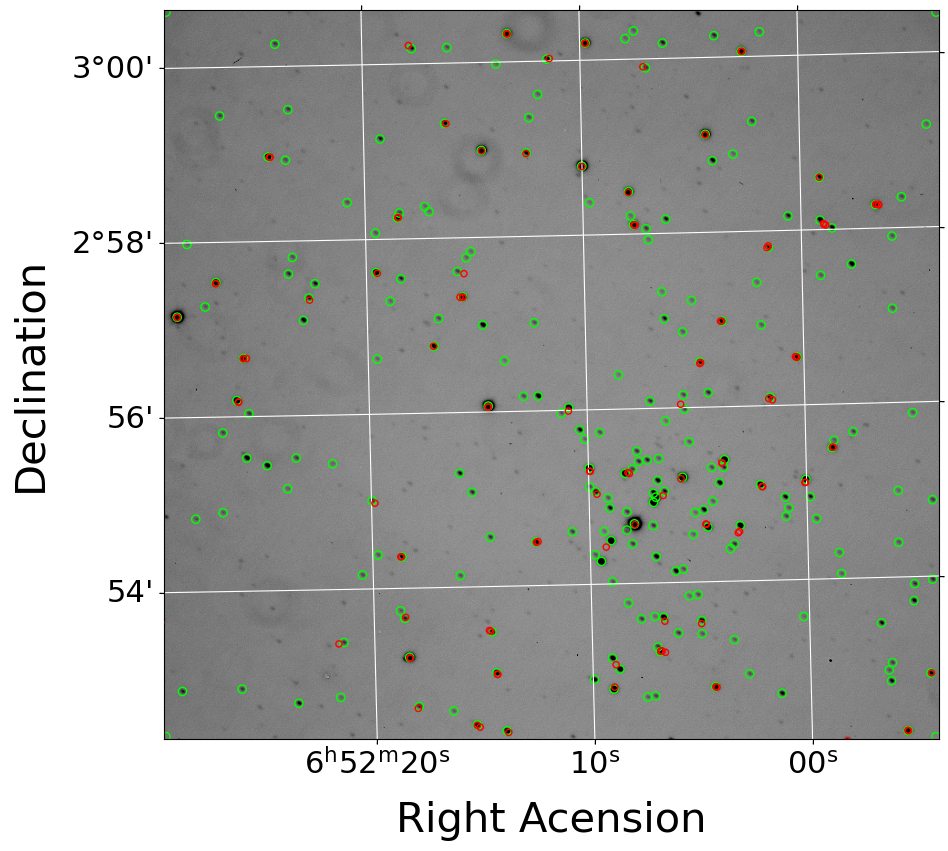

In [77]:
pixel_coords_total = []

for idx in range(0, len(test_RA)): 
    pixel_coords = Pixel_conversion(test_RA[idx], test_DEC[idx], temp_file_name)
    pixel_coords_total.append(pixel_coords)

data = fits.getdata(temp_file_name)

hdu = fits.open(temp_file_name)[0]
wcs_proj = wcs.WCS(hdu.header)
plt.subplot(projection=wcs_proj)

for star_coord in pixel_coords_total: 
    plt.scatter(*star_coord, facecolor = 'none', edgecolors='red', s = 20, zorder = 3, label = 'APASS9')

for obs_coord in tar:
    obs_RA = obs_coord.ra.degree; obs_DEC = obs_coord.dec.degree
    pixel_coords = Pixel_conversion(obs_RA, obs_DEC, temp_file_name)
    plt.scatter(*pixel_coords, facecolor = 'None', edgecolors = 'lime')

for obs_coord in DAO_common_targets:
    obs_RA = obs_coord.ra.degree; obs_DEC = obs_coord.dec.degree
    pixel_coords = Pixel_conversion(obs_RA, obs_DEC, temp_file_name)
    plt.scatter(*pixel_coords, marker = 'x', color = 'deeppink', zorder = 4)


plt.imshow(data, vmin = data.mean() - data.std(), vmax = data.mean() + data.std(), cmap = 'gist_yarg', zorder = 0)
plt.grid(color='white', ls='solid')
plt.gca().invert_yaxis()
plt.xlabel('Right Acension'); plt.ylabel('Declination')
plt.show()